In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "decision_trees"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [2]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()

X = iris['data'][:,2:]
y = iris['target']

tree_clf = DecisionTreeClassifier(max_depth=2)
tree_clf.fit(X,y)


DecisionTreeClassifier(max_depth=2)

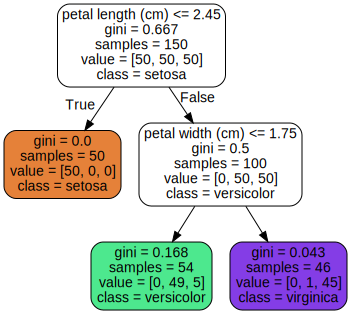

In [3]:
from graphviz import Source
from sklearn.tree import export_graphviz

export_graphviz(
        tree_clf,
        out_file=os.path.join(IMAGES_PATH, "iris_tree.dot"),
        feature_names=iris.feature_names[2:],
        class_names=iris.target_names,
        rounded=True,
        filled=True
    )

Source.from_file(os.path.join(IMAGES_PATH, "iris_tree.dot"))

In [4]:
tree_clf.predict_proba([[5,1.5]])

array([[0.        , 0.90740741, 0.09259259]])

In [5]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(max_depth=2)

tree_reg.fit(X,y)

DecisionTreeRegressor(max_depth=2)

In [13]:
from sklearn.datasets import make_moons

X,y = make_moons(n_samples=10_000, noise=.4, )


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2,random_state=42)

param_grid = {'max_leaf_nodes': list(range(2, 100)), 'min_samples_split': [2, 3, 4]}
grid_clf = GridSearchCV(DecisionTreeClassifier(), param_grid=param_grid, n_jobs=-1, verbose=1, cv=3,refit=True)

grid_clf.fit(X_train, y_train)

Fitting 3 folds for each of 294 candidates, totalling 882 fits


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                            13, 14, 15, 16, 17, 18, 19, 20, 21,
                                            22, 23, 24, 25, 26, 27, 28, 29, 30,
                                            31, ...],
                         'min_samples_split': [2, 3, 4]},
             verbose=1)

In [34]:
grid_clf.best_estimator_

DecisionTreeClassifier(max_leaf_nodes=4)

In [38]:
from sklearn.model_selection import ShuffleSplit
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import clone
from sklearn.metrics import accuracy_score



n_trees = 1000
n_instances = 100
mini_sets = []

rs = ShuffleSplit(n_splits=n_trees, train_size=n_instances)

for mini_train_index, mini_test_index in rs.split(X_train):
    X_mini_train = X_train[mini_train_index]
    y_mini_train = y_train[mini_train_index]
    mini_sets.append((X_mini_train, y_mini_train))


In [39]:
forest = [clone(grid_clf.best_estimator_) for _ in range(n_trees)]

accuracy_scores = []



for tree, (X_mini_train, y_mini_train) in zip (forest,mini_sets):
    tree.fit(X_mini_train,y_mini_train)
    y_pred = tree.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test,y_pred))

In [41]:
np.mean(accuracy_scores)

0.8205

In [42]:
Y_pred = np.empty([n_trees, len(X_test)], dtype=np.uint8)

for tree_index, tree in enumerate(forest):
    Y_pred[tree_index] = tree.predict(X_test)


In [44]:
from scipy.stats import mode

y_pred_majority_votes, n_votes = mode(Y_pred, axis=0)

In [45]:
y_pred_majority_votes

array([[1, 1, 1, ..., 0, 1, 1]], dtype=uint8)

In [46]:
n_votes

array([[ 997, 1000,  998, ...,  980,  901,  854]])

In [47]:
accuracy_score(y_test, y_pred_majority_votes.reshape([-1]))

0.846

In [48]:
grid_clf.best_score_

0.8639992300287296